In [3]:
%matplotlib inline

In [30]:
# determine availability of GPU
torch.cuda.is_available()

True

In [37]:
# Train an image classifier with cifar10 dataset

import torch
# Contains dataset and data loaders for vision training
import torchvision
import torchvision.transforms as transforms

# transform.compose() to serialize a sequece of transformes to image
# ToTensor() to transform PIL image or numpy image to torch image
# channel*hight*width with range[0., 1.]
# Normalize() to normalize a tensor image with (mean, std) for n channels
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2, 
                                          )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2, 
                                         )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


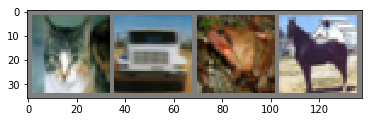

         cat        truck         frog        horse


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%12s' % classes[labels[j]] for j in range(4)))

In [51]:
import torch.nn as nn
import torch.nn.functional as F

# Define a CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        # Linear full connections
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    # Feed forward
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

# Try GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [52]:
# Define a loss function and optimizer for back propagation

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [53]:
def train(cycles):
    for _ in range(cycles):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            samples, labels = data
            samples, labels = samples.to(device), labels.to(device)
            # Zero the gradients from previous round, otherwise new grad will addon
            optimizer.zero_grad()
            # Forward prop
            outputs = net(samples)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Back prop, grad calculated automatically
            loss.backward()
            # Apply error correction to W and B automatically
            optimizer.step()
            
            # Monitor the process
            running_loss += loss.item() # Convert a scalar torch vector to python number
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                  (_ + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            

In [54]:
train(5)

[1,  2000] loss: 1.998
[1,  4000] loss: 1.720
[1,  6000] loss: 1.670
[1,  8000] loss: 1.601
[1, 10000] loss: 1.614
[1, 12000] loss: 1.583
[2,  2000] loss: 1.542
[2,  4000] loss: 1.550
[2,  6000] loss: 1.551
[2,  8000] loss: 1.542
[2, 10000] loss: 1.568
[2, 12000] loss: 1.561
[3,  2000] loss: 1.532
[3,  4000] loss: 1.531
[3,  6000] loss: 1.527
[3,  8000] loss: 1.553
[3, 10000] loss: 1.576
[3, 12000] loss: 1.537
[4,  2000] loss: 1.522
[4,  4000] loss: 1.505
[4,  6000] loss: 1.556
[4,  8000] loss: 1.536
[4, 10000] loss: 1.588
[4, 12000] loss: 1.552
[5,  2000] loss: 1.529
[5,  4000] loss: 1.570
[5,  6000] loss: 1.564
[5,  8000] loss: 1.571
[5, 10000] loss: 1.593
[5, 12000] loss: 1.591


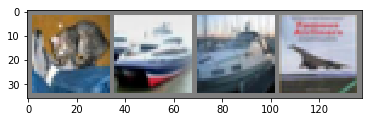

Target:       cat     ship     ship    plane


In [21]:
# Test an example

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Target: ', ' '.join('%8s' % classes[labels[j]] for j in range(4)))

In [22]:
# Generate the output from the trained ANN
outputs = net(images)
print(outputs)
# torch.max(x, 1) return the max element in each row of x tensor and the index
_, predicted = torch.max(outputs, 1)
print(predicted) # print the index
# 
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


tensor([[-1.1109, -1.4188,  0.8900,  2.1098,  0.1367,  1.0107,  1.0881, -1.0339,
          0.0330, -1.2825],
        [ 6.6142,  6.7364, -1.2571, -3.4030, -2.8709, -5.0793, -4.6117, -4.2963,
          6.6409,  3.8927],
        [ 2.4427,  1.9813, -0.0283, -0.8971, -1.4732, -2.2950, -2.8372, -1.0822,
          2.0676,  2.3716],
        [ 4.5640,  3.6291,  0.4901, -1.5064, -1.8312, -3.8180, -3.9310, -2.8585,
          4.9449,  2.0516]], grad_fn=<AddmmBackward>)
tensor([3, 1, 0, 8])
Predicted:    cat   car plane  ship


In [56]:
# Total statistics of testing
correct = 0
total = 0
# No gradient calculation is necessary during 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 79 %
Accuracy of  bird : 46 %
Accuracy of   cat : 46 %
Accuracy of  deer : 41 %
Accuracy of   dog : 25 %
Accuracy of  frog : 64 %
Accuracy of horse : 54 %
Accuracy of  ship : 74 %
Accuracy of truck : 56 %
